# Compare models qualitatively 

In [1]:
import pickle
from common import *
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
import pandas as pd

In [2]:
with open('wtv_models_yelp_only.pkl', 'rb') as infile:
    yelp_models = pickle.load(infile)

with open('wtv_models_cwiki_yelp.pkl', 'rb') as infile:
    wiki_models = pickle.load(infile)

In [3]:
for m in yelp_models:
    print(m.most_similar('nice')[:3])
print('-------------')
for m in wiki_models:
    print(m.most_similar('nice')[:3])

[('pleasant', 0.6808018684387207), ('cute', 0.6550190448760986), ('friendly', 0.6248895525932312)]
[('cool', 0.6738990545272827), ('neat', 0.6275345087051392), ('lovely', 0.6241207718849182)]
[('neat', 0.6617211103439331), ('lovely', 0.6613628268241882), ('pleasant', 0.6314660310745239)]
[('cool', 0.675835907459259), ('pleasant', 0.6456199884414673), ('neat', 0.6441613435745239)]
[('cool', 0.7131777405738831), ('pleasant', 0.662418007850647), ('neat', 0.6618289351463318)]
-------------
[('neat', 0.7795519828796387), ('cute', 0.7674884796142578), ('friendly', 0.7574198842048645)]
[('lovely', 0.7970020174980164), ('cool', 0.7913711667060852), ('cute', 0.7586115002632141)]
[('cool', 0.7654863595962524), ('lovely', 0.7340822219848633), ('great', 0.7330889701843262)]
[('cool', 0.7509998083114624), ('lovely', 0.7368682622909546), ('pleasant', 0.7041727304458618)]
[('cool', 0.7659857273101807), ('pleasant', 0.7405916452407837), ('lovely', 0.7199037075042725)]


### Inversion of the distributed representations

At this point, we have 5 different word2vec language representations.  Each 'model' has been trained conditional (i.e., limited to) text from a specific star rating.  We will apply Bayes rule to go from _p(text|stars)_ to _p(stars|text)_.

For any new sentence we can obtain its _likelihood_ (lhd; actually, the composite likelihood approximation; see the paper) using the [score](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.score) function in the `word2vec` class.  We get the likelihood for each sentence in the first test review, then convert to a probability over star ratings. Every sentence in the review is evaluated separately and the final star rating of the review is an average vote of all the sentences. This is all in the following handy wrapper.

In [4]:
"""
docprob takes two lists
* docs: a list of documents, each of which is a list of sentences
* models: the candidate word2vec models (each potential class)

it returns the array of class probabilities.  Everything is done in-memory.
"""

def docprob(docs, mods):
    # score() takes a list [s] of sentences here; could also be a sentence generator
    sentlist = [s for d in docs for s in d]
    # the log likelihood of each sentence in this review under each w2v representation
    llhd = np.array( [ m.score(sentlist, len(sentlist)) for m in mods ] )
    # now exponentiate to get likelihoods, 
    lhd = np.exp(llhd - llhd.max(axis=0)) # subtract row max to avoid numeric overload
    # normalize across models (stars) to get sentence-star probabilities
    prob = pd.DataFrame( (lhd/lhd.sum(axis=0)).transpose() )
    # and finally average the sentence probabilities to get the review probability
    prob["doc"] = [i for i,d in enumerate(docs) for s in d]
    prob = prob.groupby("doc").mean()
    return prob


#### Test set example

As an example, we apply the inversion on the full test set.  

In [15]:
# read in the test set
revtest = list(YelpReviews("test"))
X = [r['x'] for r in revtest]
gold = np.array([r['y'] for r in revtest])

In [42]:
def evaluate(X, models):
    gold = np.array([r['y'] for r in revtest])
    probs = docprob(X, models)
    probpos = pd.DataFrame({"out-of-sample prob positive":probs[[3, 4]].sum(axis=1), 
                            "true stars":gold})
    probpos.boxplot("out-of-sample prob positive",by="true stars", figsize=(12,5));
    
    preds = probs.values.argmax(axis=1) + 1 # gold is 1..5, predictions are 0..4
    print('5-way Accuracy', accuracy_score(preds, gold))
    
    # three-way classification
    probs3 = np.vstack([probs.values[:, :2].sum(axis=1),
                          probs.values[:, 2],
                          probs.values[:, 3:].sum(axis=1)]).T
    gold = np.array([r['y'] for r in revtest])
    gold[gold<3] = 1
    gold[gold==3] = 2
    gold[gold>3] = 3
    preds = probs3.argmax(axis=1) + 1 # gold is 1..5, predictions are 0..4
    print('5-way Accuracy', accuracy_score(preds, gold))

5-way Accuracy 0.570744032061
5-way Accuracy 0.812859383168


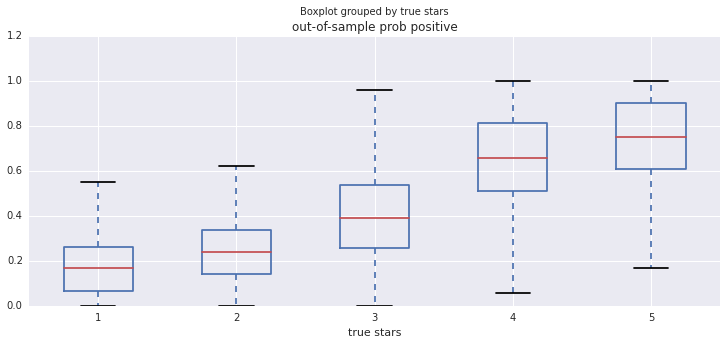

In [43]:
probs = evaluate(X, yelp_models)

5-way Accuracy 0.559635825057
5-way Accuracy 0.802317476912


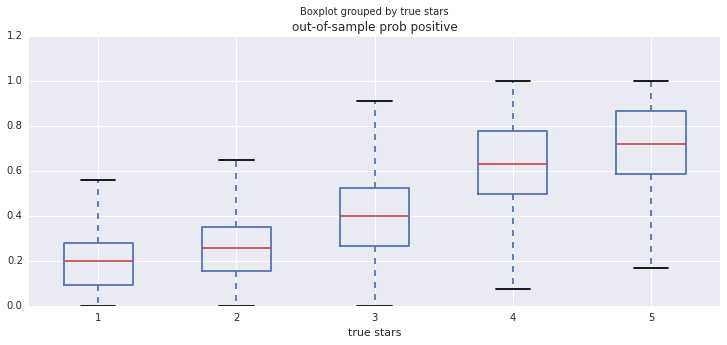

In [44]:
evaluate(X, wiki_models)